# Tutorial 2 - Transition Goals and Integrated Assessment models
## A first look at integrated assessment models

Week 2, Day 3: IPCC Socio-economic Basis

By Neuromatch Academy

Content creators: Maximilian Puelma Touzel

Content reviewers: Name Surname, Name Surname

Content editors: Name Surname, Name Surname

Production editors: Name Surname, Name Surname

Our 2023 Sponsors

---
# Tutorial Objectives

To understand in a relatively simple Integrated Assessment Model (IAM) how parameters that set how we distribute value in society affect the corresponding optimal climate policy.

---
# Setup
Import libraries

In [1]:
from IPython.display import Math
from IPython.display import display, HTML, Image,IFrame
import seaborn as sns
import matplotlib.pyplot as pl
import pandas as pd
import numpy as np
import dicelib

FIgure settings

In [2]:
%matplotlib inline
sns.set_style("ticks", {'axes.grid': False})
params = {'lines.linewidth': '3'}
pl.rcParams.update(params)
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
def plot_future_returns(gamma, random_seed):
    fig,ax=pl.subplots(1,2,figsize=(8,4))
    np.random.seed(random_seed)
    undiscounted_utility_time_series = np.random.rand(time_steps)
    ax[0].plot(undiscounted_utility_time_series)

    discounted_utility_time_series=undiscounted_utility_time_series*np.power(gamma,np.arange(time_steps))
    ax[0].plot(discounted_utility_time_series)

    cumulsum_discounted_utility_time_series=np.cumsum(discounted_utility_time_series)
    ax[1].plot(cumulsum_discounted_utility_time_series*(1-gamma),color='C1',label=r'discounted on $1/(1-\gamma)=$'+'\n'+r'$'+str(round(1/(1-gamma)))+'$-step horizon',)
    cumulsum_undiscounted_utility_time_series=np.cumsum(undiscounted_utility_time_series)
    ax[1].plot(cumulsum_undiscounted_utility_time_series/cumulsum_undiscounted_utility_time_series[-1],label='undiscounted',color='C0')
    ax[1].axvline(1/(1-gamma),ls='--',color='k')


    ax[0].set_ylabel('utility at step t')
    ax[0].set_xlim(0,time_steps)
    ax[0].set_xlabel('time steps into the future')
    ax[1].legend(frameon=False)
    ax[1].set_ylabel('future return (normalized)')
    ax[1].set_xlabel('time steps into the future')
    ax[1].set_xlim(0,time_steps)
    fig.tight_layout()

---
# Section 1: background on IAM economics and the DICE model

The Dynamic Integrated Climate-Economy (DICE) was the first prominent Integrated Assessment model, a class of models economists use to inform policy decisions. Like world3, it's too idealized to be predictive. DICE is still useful as a sandbox for climate policy ideas (though even in that it could be improved! c.f.  https://www3.nd.edu/~nmark/Climate/DICE-simplified_2019.pdf), which is how we will use it here.

### Brief description
- The DICE is a fully aggregated (ie. non-spatial) model, but otherwise contains the essence of many key components of more complex IAMs. 
- Unlike World3 (from tutorial 1), the world models used in IAMs usually have *exogeneous* variables, ie. those that are set externally, in addition to fixed world system parameters. These exogeneous variables are assumed to be under our society's control. 
- IAMs come equipped with an objective function that returns how valuable is a projected future obtained from running the world model under a given climate policy defined by time series of these exogeneous variables. In this sense, the objective function is what defines "good" in "good climate policy". 
- The computation in an IAM is then optimization of this objective as a function of the time series of these exogeneous variables over some fixed time window. In DICE, these exogeneous parameters are the time-dependent mitigation (i.e. emissions reduction) rate $\mu(t)$ limiting warming-caused damages, and a savings rate, $S(t)$, driving capital investment (discussed below). 
- The choices for the standard values of the parameters used in the DICE models have been critisized, and updated versions have been analyzed and proposed (Hansel et al. 2021). Here, we look at the standard DICE2016 version of the model.

For anyone new to establishment (socalled *neo-classical*) economics, it's worth first going over some basics. (notation: lower case versions of variables are for individuals, upper case for populations). Let's start with utility, a central concept not only for economics but also all decision theory, the field in which the activity of *planning* is formalized mathematically.

# Utility

Economic value, or *utility*, of a state of the world for an individual is quantified by the consumption conferred (capital consumed). 

Reducing value to consumption may seem restrictive, and it is, but it's how most economists see the world (not all! c.f. Hüttel, Balderjahn, & Hoffmann,
*Welfare Beyond Consumption: The Benefits of Having Less* Ecological Economics (2020)). That said, economists don't think utility is identically consumption. Let's work through the assumptions in a standard presentation of the economics that links the two.

### Utilities at different levels of consumption
It's natural that the utility of consumption is relative to the level of consumption. A crude illustration here is that the value of a meal is higher to those who haven't eaten recently than for those who have. Thus, we assume units of consumption at low values confer more utility than those at high values, or equivalently,
 * **a unit of consumption has less value to an individual the more that individual tends to consume overall**.

Plot the utility function for different values of its one parameter called the elasticity and denoted $\alpha$.

Text(0, 0.5, 'utility, u(c)')

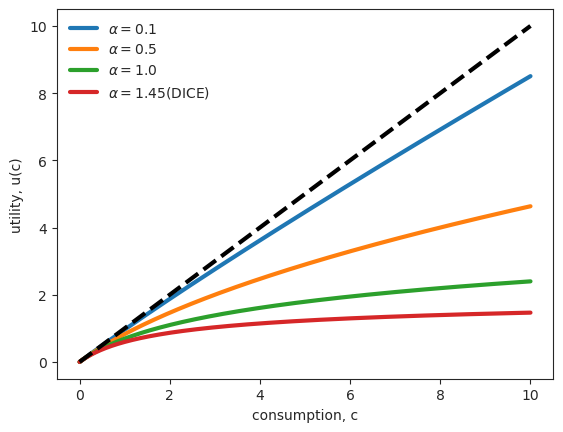

In [4]:
fig,ax=pl.subplots()
c = np.linspace(0,10,1000)
for alpha in [0.1,0.5,1.0, 1.45]:
    if alpha==1:
        ax.plot(c,np.log(1+c),label=r'$\alpha='+str(alpha)+'$')
    elif alpha==1.45:
        ax.plot(c,((c+1)**(1-alpha)-1)/(1-alpha),label=r'$\alpha='+str(alpha)+'$(DICE)')
    else:
        ax.plot(c,((c+1)**(1-alpha)-1)/(1-alpha),label=r'$\alpha='+str(alpha)+'$')

ax.plot([0,10],[0,10],'k--')
ax.legend(frameon=False)
ax.set_xlabel('consumption, c')
ax.set_ylabel('utility, u(c)')

*Exercise*: what do you think the function looks like for $\alpha=0$?

*Answer*:

### Utilities over a population
In the case that individuals are of the same type, a population of such individuals we are assuming that 
* **utilities of individuals of the same type sum**.

### Utilities over time
Since our actions now affect those in the future (the socalled *intertemporal choice problem*), we can't decide what is best to do at each time point by looking only at how it affects the world at that time. We need to incorporate utilities from the future into our value definition to know what is best to do now. How should we combine these? 

Economists and decision theorists typically assume that a unit of utility is worth less the further into the future it is received. This is justified by pointing to the inherent uncertainty of this future event and the finite probability that it might not come to pass. This means
* **utilities in the near future are valued more than those in the far future.**

This devaluation of the future is called temporal discounting. You can imagine that there is alot of debate about how and even whether to do this in climate policy design! 

The standard approach is to multiply the utilities of future benefits and costs by a discount factor (called $\gamma$ ('gamma') that is a number just less than 1, e.g. 0.95) that is raised to the power of time into the future: 
- after 1 year $(0.95)^1=0.95$
- after 2 years $(0.95)^2=0.90$
- after 10 years $(0.95)^3=0.60$

In the following toy illustration of temporal discounting, 
- vary gamma from 0.95 to 0.99 to see how (uncertain) projected future rewards (blue) are scaled down when summed to compute a value (e.g. of a current action). The black dashed line shows the effective time horizon beyond which rewards are ignored (set by the natural convention of when the return gets to a fraction ($1-1/e\approx0.64$) of the final value). 

Question: what $\gamma$ gives a horizon of 200?

- The projected rewards are uncertain. Here, we uniformily sample them to increment the random seed from 1 to 2 to see how much it depends on the the particular random sequence of the rewards.

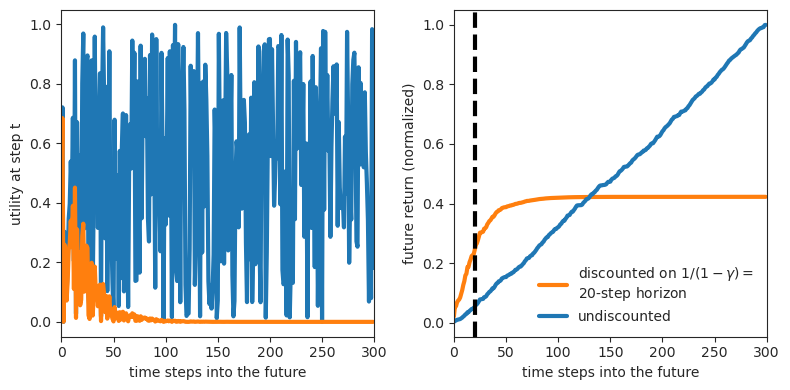

In [5]:
time_steps=300
gamma=0.95
random_seed=1
plot_future_returns(gamma,random_seed)

Observe how the shorter the horizon, the sooner future discounted return saturates and no utility from further time steps contributes to the value. In contrast for the undiscounted case, all future times matter equally and the future return grows linearly with the upper time to which utilities are computed. 

### Utilities over different populations
Now, let's consider the case that there are populations of individuals of *different* types (e.g. different blocks of countries in the world economy). In a centralized planning setting, how do we value the utilities of each relative to each other when combining them into a single utility?
Such a function is called a Social Welfare Function (SWF). E.g. we can add them together (the socalled *utilitarian* SWF) or we can multiply them together (the socalled *Nash* SWF).

For a more mathematical treatment on utility functions unhide the following hidden cell.

If you are interested in the math of marginal utility, read this, otherwise continue to the next cell:

Here is a list the variables we will define:
- $\alpha$ elasticity parameter
- $c$ indiviudal consumption
- $C$ population consumption
- $u(c)$ individual utility
- $L$ labor (number of individuals)
- $U(C,L)$ population utility
- $V$ value (expected total future costs and benefits)
- $W(U_1,\dots, U_N)$ social welfare over $N$ populations

Economic elasticity is the percentage change of one economic variable in response to a percentage change in another, $\frac{dy(x)}{dx}\frac{x}{y(x)}$ (e.g. linear relationships give elasticity of 1). For utility as a function of consumption, let's assume 
* **a constant elasticity** 

for all consumption values, $c$, (also called the isoelastic case) parametrized by convention using $\alpha=1-\frac{du(c)}{dc}\cdot \frac{c}{u(c)}$. We can solve this differential equation and apply the convention $u(0)=0$ as a boundary condition to obtain the utility function, $$u(c)=\frac{(c+1)^{1-\alpha}-1}{1-\alpha},$$ where $c\geq0$ and dimensionless, i.e. set in some multiples of some standard unit like 1 Big Mac, or more conventionally USDs. 

Utility is thus a monotonically increasing function with decreasing derivative or *marginal utility*, $\frac{du}{dc}=c^{-\alpha}$. 

A linear relationship between consumption and utility is obtained for $\alpha=0$. Note that this function includes the case of zero elasticity ($\alpha=1$), in which case l'H&#244;pital's rule gives $u(c)=\log (1+c)$ (alternatively, write $1+c=e^{\log (1+c)}$ in the expression for $u(c)$ and expand the exponential to linear order in $1-\alpha$).

In the case that individuals are of the same type, a population of $L$ such individuals (termed $L$ for labor force) that has consumption $C$, equally spread among its members, i.e. per capita consumption, $C/L$, equal to the consumption of each member, $c_l$, $l=1,\dots,L$. The joint utility for this population is $$U(C,L)=\sum_{l=1}^Lu(c_l)=Lu(C/L).$$ 


The standard formulation (*exponential discounting*) is to multiply projected future utilities by increasing powers of a discount factor, $\gamma$ (corresponding to the assumption of a constant hazard rate (c.f. Sozou (1998)), before summing them. For example, the value, $V$, of a projection given a policy over this window is
$$V=\sum_{t=1}^{\infty}\gamma^t U(c_t)$$ where $c_t$ is the projected consumption $t$ steps into the future. Economists parametrize $\gamma$ using a discount rate $\rho$, $\gamma=1/(1+\rho)$, such that the characteristic horizon timescale after which future utility is ignored is $\rho^{-1}$ time steps (in practise then the sum can be truncated to a finite time window a few multiples of $\rho^{-1}$ without affecting the value).

Consider the following family of *social welfare functions* (*social* is used here simply because there is more than 1) that combine the utilities of $N$ groups (assuming these are discounted returns as computed above), $$W(U_1,\dots, U_N)=\sum_{i=1}^N U^\beta_i$$ The choice of exponent parameter $\beta$ specifies the kind of welfare function. The socalled utilitarian choice is to set $\beta=1$, such that it is a sum that gives equal weight to each group. Alternatively, $\beta<1$ is a case analogous to how we transformed consumption to utility above ($\beta$ analogoues to $1-\alpha$) in a way that overweighs lower consumption. Here this means prioritizing groups having lower utility so it's called the prioritarian choice (studied in the context of climate policy by Adler et al. *Nat. Clim. Change* (2017)). Fairness excludes all cases of $\beta>1$. Note that the case of $\beta$ near 0 gives $$\frac{W(U_1,\dots, U_N)-N}{\beta}=\sum_{i=1}^N\log U_i =\log\prod_{i=1}^{N}U_i.$$
Both the logarithm, subtraction by $N$ and rescaling by $1/\beta$ do not change the ordering of joint utilities induced by $W$. The result is then simply the product of utilities, called the Nash social welfare function. It is a natural fairness function and has many solution methods associated with it (see game theory literature).

# Damage functions

The central model object linking climate and socio-economic processes in integrated assessment models is the damage function.

These are the objects in the model that dictate how changes in temperature affect production (e.g. through direct weather-related damage). They are thus hugely important but unfortunately are estimated using ad hoc functional forms and a largely unjustifiable methodology that extrapolates from historical and geographic variability. (c.f. *The appallingly bad neoclassical economics of climate change* by S. Keen in *Globalizations* (2020) )

The standard form is a deterministic continuous function that maps changes in temperature, $\Delta T$ to the fraction, $\Omega$, of productivity that is destroyed by climage change every year. The standard parametrization is a quadratic dependence 
$$\Omega=a \times (\Delta T)^2$$
where $a$ is some small (e.g. 0.001) constant set by compariing with geographic and historical variation. Let's plot this function. For more contemporary damage functions see van der Wijst et al. *Nat. Clim. Change* (2023).

(0.0, 0.05)

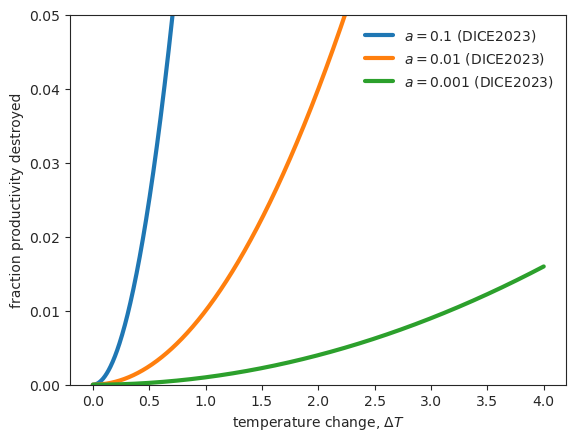

In [6]:
fig,ax=pl.subplots()
T = np.linspace(0,4,1000)
a1 = 0.00236  # Damage quadratic term                     /0.00236/
a2 = 2.00  # Damage exponent 
for a1 in [0.1,1e-2,1e-3]:
    ax.plot(T,a1*(T**a2),label=r'$a='+str(a1)+'$ (DICE2023)')
ax.legend(frameon=False)
ax.set_xlabel('temperature change, $\Delta T$')
ax.set_ylabel(r'fraction productivity destroyed')
ax.set_ylim(0,0.05)

Observe how larger temperature changes lead to a larger fraction of productivity desroyed. This drop is due to the putative damages caused by that temperature.

*Exercise*: Brainstorm reasons why a deterministic, continuous mapping between temperature and economic damage might not reflect, even qualitatively, the causal processes underlying the relationship between the two?

(E.g. in a toy picture, what is the economic damage to coastal city subway systems as a function of change in height of sea level?)

## IAM model summary 

The economy model in most IAMs is a capital accumulation model. 
- Capital combines with a laboring population and technology to generate productivity ($Y$) that is hindered by climate damage. 
- A savings fraction of production drives capital accumulation while the rest is consumed. Welfare is determined by consumption.
- Climate action is formulated by a mitigation rate, $\mu$, which along with the savings rate are the two control parameters in the model.
- These are used to maximize welfare.

The climate model in DICE could be improved (c.f. https://www3.nd.edu/~nmark/Climate/DICE-simplified_2019.pdf). We only summarize here how it interacts with the economy model:
- Productivity generates industrial emissions, $$E_\mathrm{ind}=(1-\mu)\sigma Y,$$ where the $1-\mu$ factor accounts for reduced carbon intensity of production, $\sigma$, via supply-side mitigation measures (e.g. increased efficiency). 
- The productivity $Y$ rather than output production ($Q$) see model is used here because damages aren't included. 
- Namely, the emissions produced in the process of capital production occur before climate change has a chance to inflict damage on the produced output. 
- These emissions combine with natural emissions to drive the temperature changes appearing in the damage function, closing the economy-climate loop. 



For a more mathematical treatment, unhide the following hidden cell

Here are a list of variables used:
- $K$ capital
- $Y$ productivity
- $Q$ production
- $A$ technology conversion
- $S$ savings rate
- $\mu$ mitigation rate
- $\Lambda$ mitigation cost
- $\Omega$ damage fraction of productivity
- $\sigma$ carbon intensity of production
- $E$ emissions

### Exogeneous control variables
There are two exogeneous variables in the model:
- mitigation (emissions reduction) rate $\mu_t$, and 
- the savings rate $S_t$. 

There is a mitigation cost associated with a given mitigation rate given as the fraction of productivity, $\Lambda_t=\theta_1\mu^{\theta_2}$, such that mitigating more costs more. 

The savings rate $S_t$ pulls out a fraction of production to invest to drive up capital, with the remaining production consumed.

## Economy model summary
The essence of the economy model in DICE is a capital accumulation model. Existing capital depreciates at rate $\delta$ and new capital arises through investment,
$$K_{t+1}=(1-\delta)K_t+I_t$$
where the invested capital $I=SQ$ is determined by a chosen fraction $S$ of the production $Q$ that is "saved" rather than consumed. Production is given as the productivity $Y$ reduced by damages and mitigation cost, $$Q=(1-\Omega)(1-\Lambda)Y.$$ Productivity, $$Y=A K^\gamma L^{1-\gamma},$$
is determined by the technology conversion $A$ operating on a combination of capital $K$ and labor $L$ whose relative contributions are set by the capital elasticity parameter $\gamma$. Labor is population which set to saturate over the 2nd half of the 21st century. Technology conversion is only weakly sigmoidal in time, deviating slightly from linear growth.

The remaining production is consumed $$C:=(1-S)Q$$ producing utility $$U(C,L)=Lu(c)=Lu(C/L),$$ using the isoelastic utility function, $$u(c)=\frac{(c+1)^{1-\alpha}-1}{1-\alpha}.$$ The overall value of a projected future is then $$V=\sum_{t=1}^{\infty}\gamma^t U(C_t,L_t),$$ where $\gamma=1/(1+\rho)$ for discount rate $\rho$ and we use the population level utility function $U(C,L)=Lu(C/L)$.

## Optimal Planning
The uncontrained problem is simply to maximize $V$ over the space of time courses of $\mu_t$ and $S_t$ (although with bound constraints on $\mu$ and $S$). Why is there a sweet spot? Savings increases investment and thus productivity, but the resulting higher production drives emissions, driving up temperature and resulting in damages that scale down production. Mitigation costs balance this latter effect such that there typically exists a non-trivial joint time series of $\mu_t$ and $S_t$ that maximizes $V$. Because of the discount factor $\gamma$, $V$ is only determined by the future sequence of consumption (non-invested production) a few multiples of the horizon, $1/(1-\gamma)$ time steps into the future.

Constrained formulations add the constraint of industrial emissions below some value. 

## Social cost of carbon

A definition for the social cost of carbon (SCC) is 

- *the decrease in aggregate consumption in that year that would change the current...value of social welfare by the same amount as a one unit increase in carbon emissions in that year.* (Newbold, Griffiths, Moore, Wolverton, & Kopits, 2013). 

The $SCC$ quantifies how much consumption is lost with increased emissions, using changes in welfare to make the connection. In technical terms: 

- the marginal value with respect to emissions relative to the marginal value with respect to consumption, $$SCC_t\propto\frac{\partial V/\partial E_t}{\partial V/\partial C_t}=\frac{\partial C_t}{\partial E_t}.$$
This is usually expressed by multiplying by a proportionality factor of $-1000$ that converts the units to 2010 US dollars per tonne of CO2. 

Now you have a sense for how climate economists dervie optimal plans, here via the specification of a welfare function for society that serves as a basis to rank and select different climate policies defined via time-varying rates of mitigation and capital investment. 

# Section 2: DICE simulations
Now, let's move to the DICE model that gives us some control over our emissions and consumption to see the effect of varying the parameters arising from the above design choices.

We'll use a `Python` implementation of the DICE2016 model (https://github.com/hazem2410/PyDICE) that I refactored into a class and made a few other changes to make it easier to vary parameters (https://github.com/mptouzel/PyDICE/blob/master/dicelib.py). 
N.b. that the DICE model was recently updated ([DICE2023](https://www.nber.org/papers/w31112)).

The model equations are described in the associated document that can be downloaded: https://github.com/hazem2410/PyDICE/blob/master/PyDICE2016.pdf. The notation is similar, but not identical.

*Exercise*: Open `dicelib.py` in the local folder and look at the list of parameter definitions. Take only a couple minutes to crosscheck a couple of them with the equations in the pdf above.

## Case 1 Run standard run

Let's run the standard run

In [7]:
dice_std = dicelib.DICE()  #create an instance of the model
dice_std.init_parameters()
dice_std.init_variables()
controls_start_std,controls_bounds_std=dice_std.get_control_bounds_and_startvalue()
dice_std.optimize_controls(controls_start_std,controls_bounds_std);

/home/mptouzel/miniconda3/lib/python3.10/site-packages/scipy/optimize/_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Optimization terminated successfully    (Exit mode 0)
            Current function value: -4517.318955182418
            Iterations: 95
            Function evaluations: 19232
            Gradient evaluations: 95


Check that the optimal control solution is within the bounds we set:

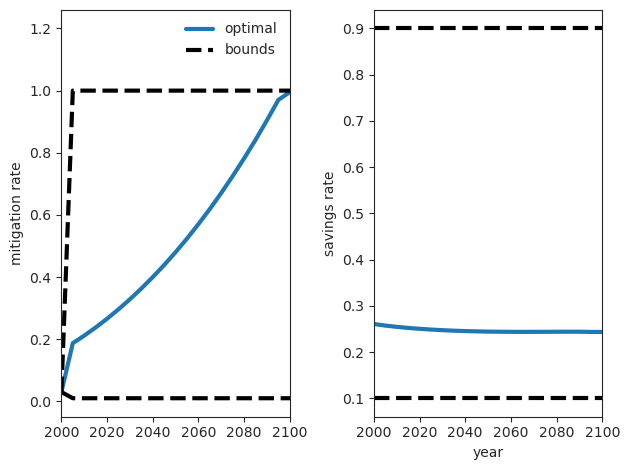

In [8]:
fig,ax=pl.subplots(1,2)
max_year=2100
TT=dice_std.TT
NT=dice_std.NT
upp,low=zip(*controls_bounds_std[:NT])
ax[0].plot(TT,dice_std.optimal_controls[:NT],label='optimal')
ax[0].plot(TT, upp,'k--',label='bounds')
ax[0].plot(TT,low,'k--')
ax[0].set_ylabel('mitigation rate')
ax[0].set_xlim(2000,max_year)
ax[0].legend(frameon=False)
upp,low=zip(*controls_bounds_std[NT:])
ax[1].plot(TT,dice_std.optimal_controls[NT:])
ax[1].plot(TT,upp,'k--')
ax[1].plot(TT,low,'k--')
ax[1].set_ylabel('savings rate')
ax[1].set_xlabel('year')
ax[1].set_xlim(2000,max_year)

fig.tight_layout()

*Exercise*: change `max_year` in the cell above to see what happens after 2100. What does the mitigation rate do?

The model aims include the effects of negative emission technologies by allowing the mitigation rate (via the bounds) to go greater than 1 at about 2140. Note that the solution definitely makes use of this and would do so before 2100 if allowed. The decision to allow this behaviour came from modellers realizing it allowed feasible solutions for some the higher forcing SSP scenarios that up to then didn't have any.
There was a vigorous debate about this at the time. It was mostly lost and mitigations rates larger than 1 have become a standard feature of many models in high forcing regimes (e.g. See Anderson & Peters *Science* 2016 for arguments for why we shouldn't allow mitigation rates critique of allowing this to happen). 
We’ll look at sociological aspects like these in the last two tutorials.

What do the rest of the variables look like: 

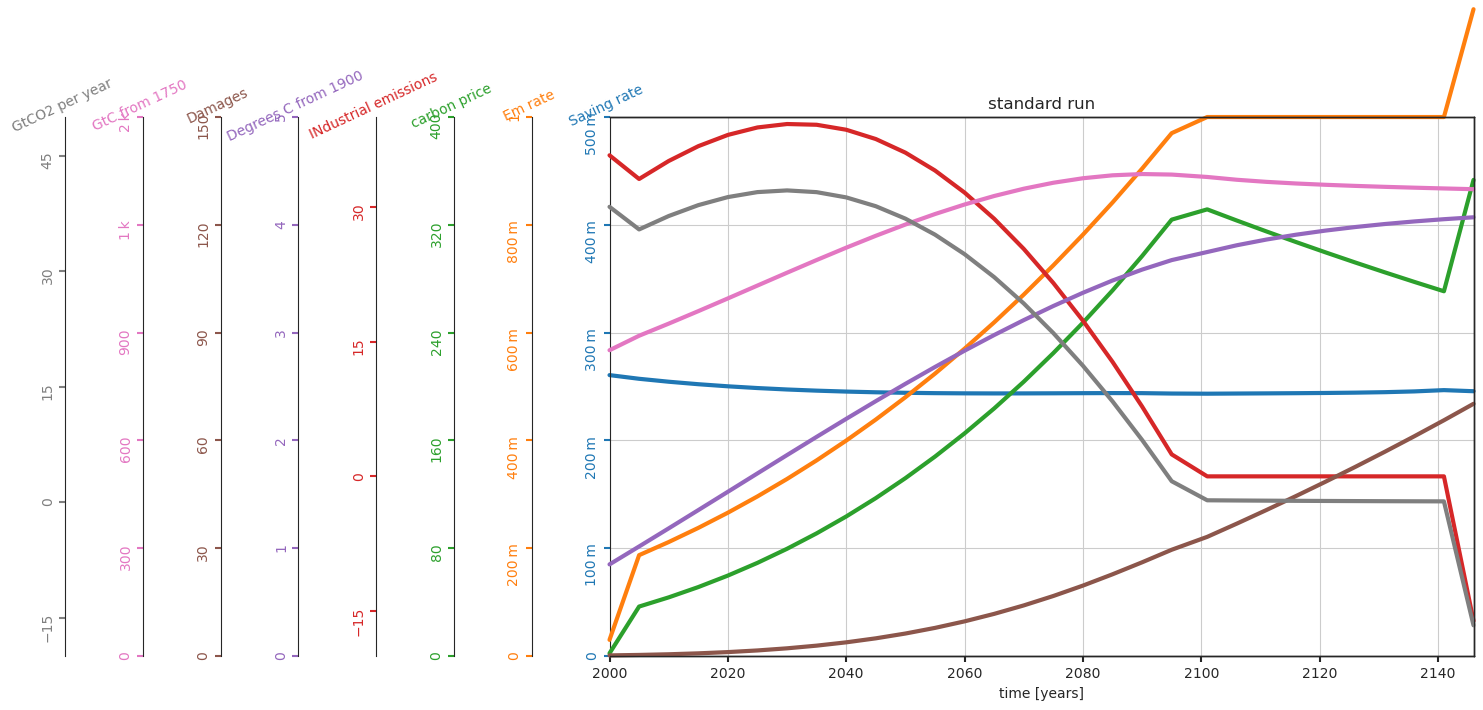

In [9]:
dice_std.roll_out(dice_std.optimal_controls)
dice_std.plot_run('standard run')

So the carbon price (green) roughly tracks the mitiation rate (Em rate). The emissions rate roughly tracks the industrial emissions. Cumulative emissions peak around 2090 (since NETS aren't used until 2140). 

## Case 2 Damage functions

How fast we scale up mitigation efforts in the standard run depends on how much damage climate change is projected to cause, which is set by the parameters of the damage function. How sensitive is our response to these parameters?

*Exercise*: Change strength of the nonlinearity in the damage function by changing the exponent from 2 to 3.

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4517.318955182418
            Iterations: 95
            Function evaluations: 19232
            Gradient evaluations: 95
Optimization terminated successfully    (Exit mode 0)
            Current function value: -4416.943986431243
            Iterations: 91
            Function evaluations: 18426
            Gradient evaluations: 91


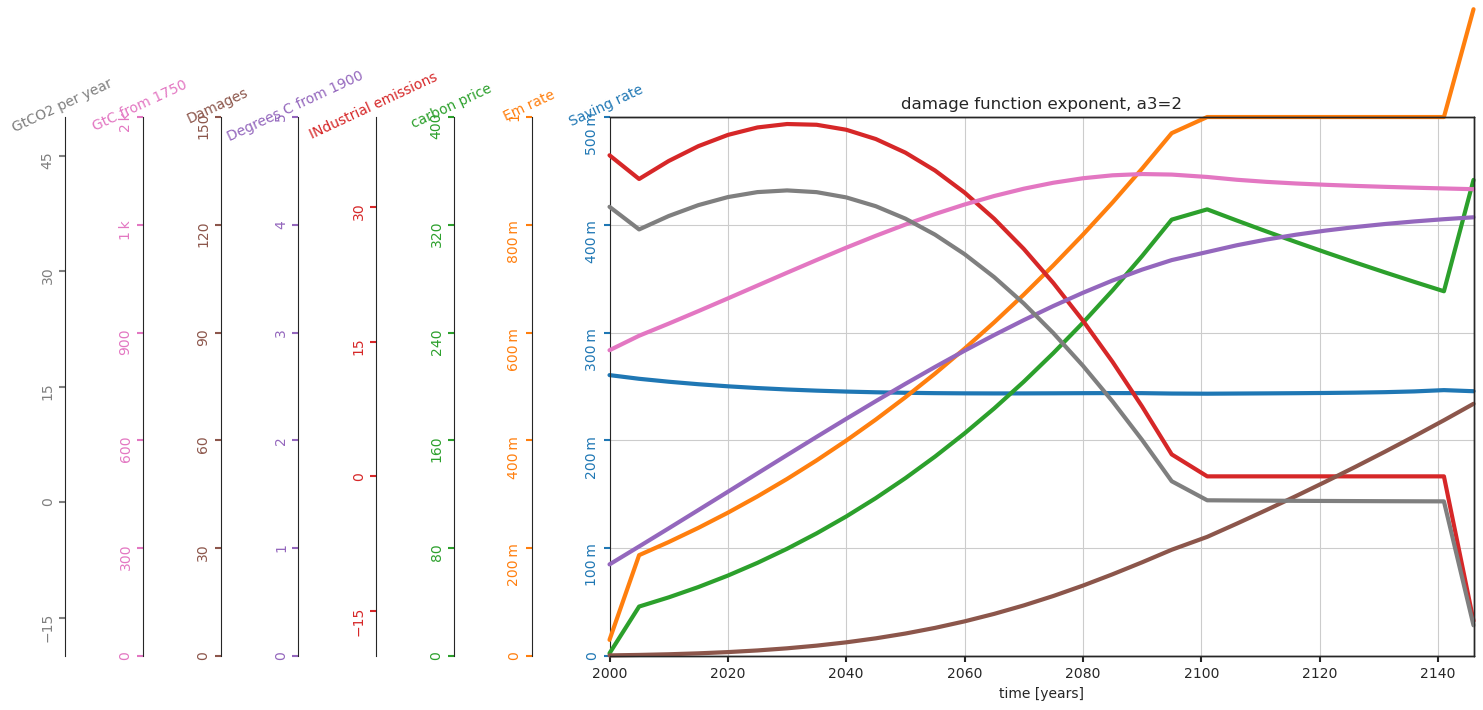

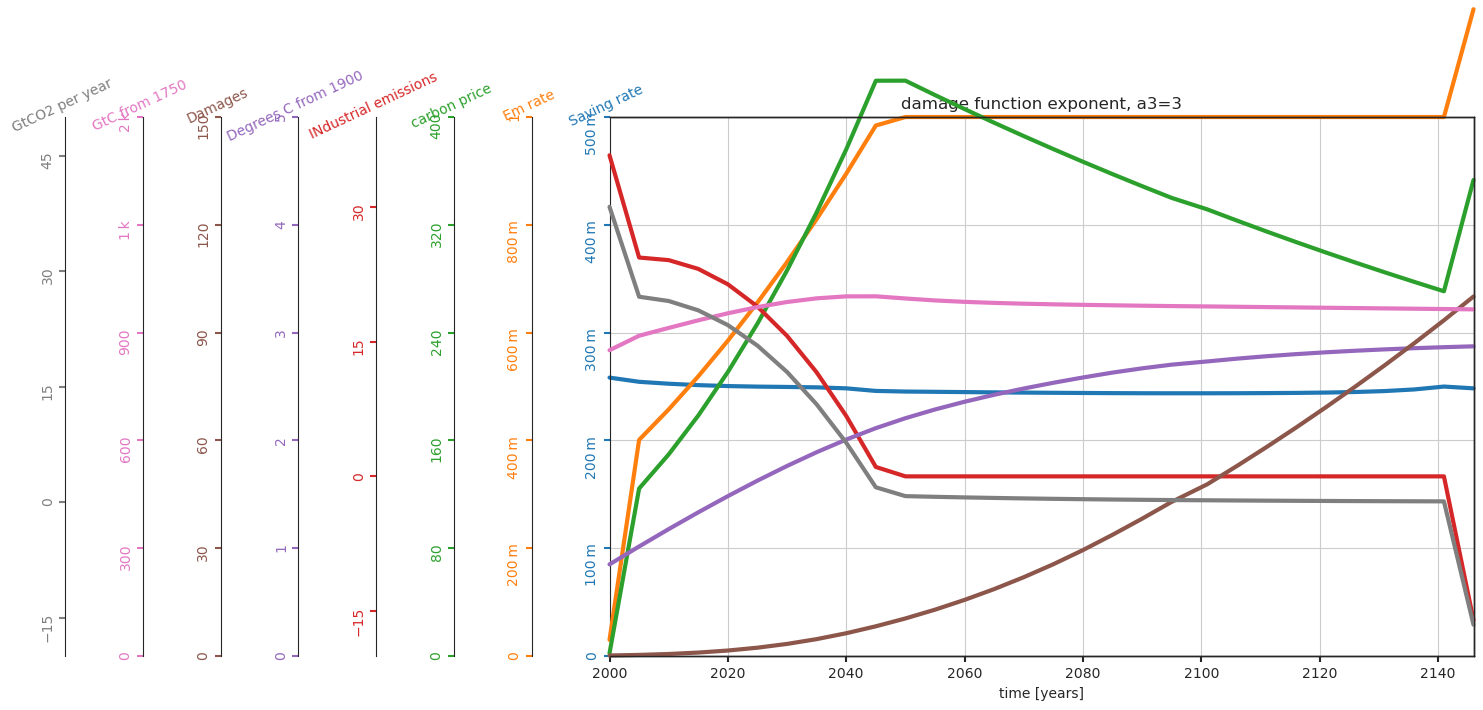

In [10]:
for a3 in [2,3]:
    dice = dicelib.DICE()
    dice.init_parameters(a3=a3)
    dice.init_variables()
    controls_start,controls_bounds=dice.get_control_bounds_and_startvalue()
    dice.optimize_controls(controls_start,controls_bounds)
    dice.roll_out(dice.optimal_controls)
    dice.plot_run('damage function exponent, a3='+str(a3))

Question: What are the main differences between these two projections?

IAMs model climate damages as affecting productivity only in the year in which they occur. What if the negative effects on productivity persist into the future? A persistence time can be added to damages such that a damage incurred in one year can continue affecting productivity into following years (c.f. Schultes et al. *Environ. Res. Lett.* (2021); Hansel et al. *Nat. Clim. Change* (2020)). These effects are not negligible, but are absent from current IAMs used by the IPCC.

## Case 3: discount rate

The value definition includes exponential temporal discounting at a rate of r=1.5% per year so that utility obtained $t$ years into the future is scaled down by $1/(1+r)^t$. What if we set this rate lower so that we don't down scale as quickly and so incorporate more in the value definition of what happens in the future when we make decisions?

*Exercise*: Change the discount rate from 1.5% to 0.5% (c.f. Arrow et al. *Science* (2013))

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4517.318955182418
            Iterations: 95
            Function evaluations: 19232
            Gradient evaluations: 95
Iteration limit reached    (Exit mode 9)
            Current function value: -42975.48901732729
            Iterations: 100
            Function evaluations: 20282
            Gradient evaluations: 100


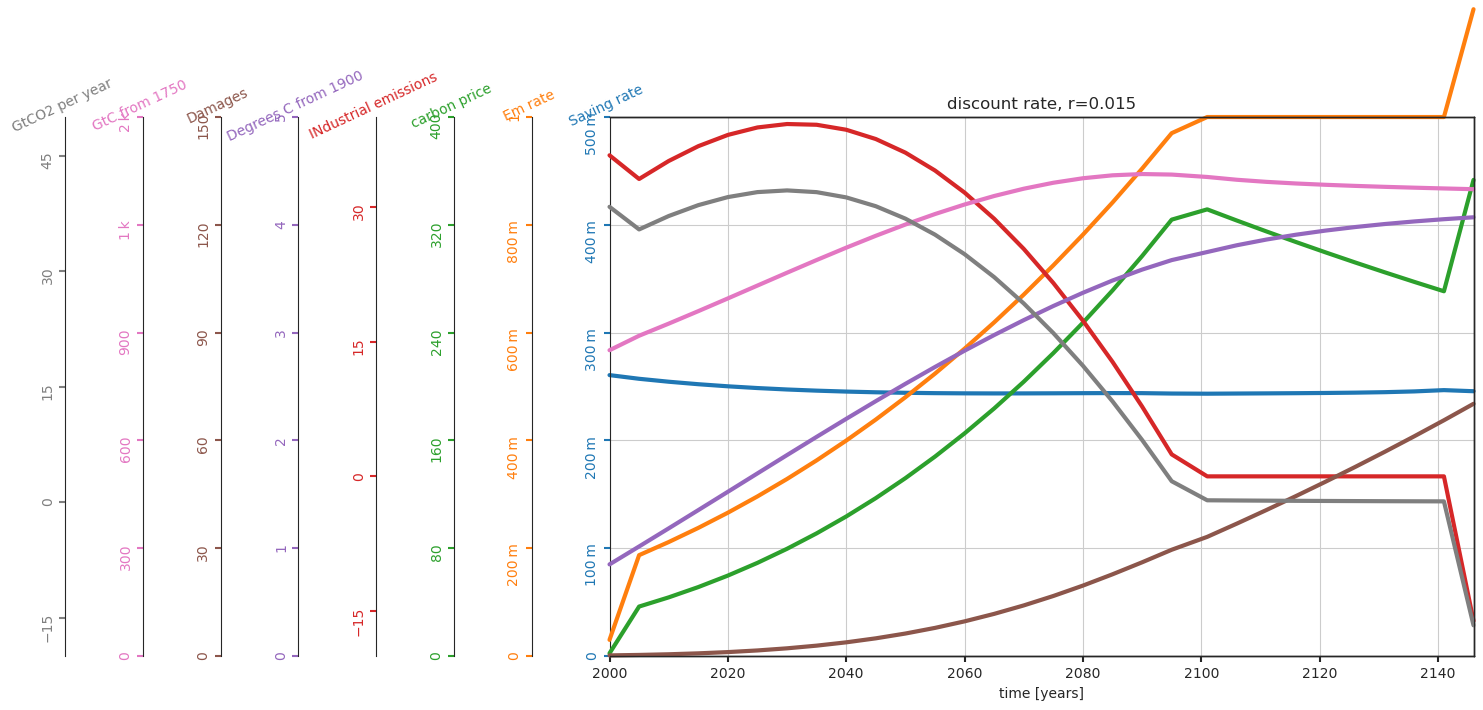

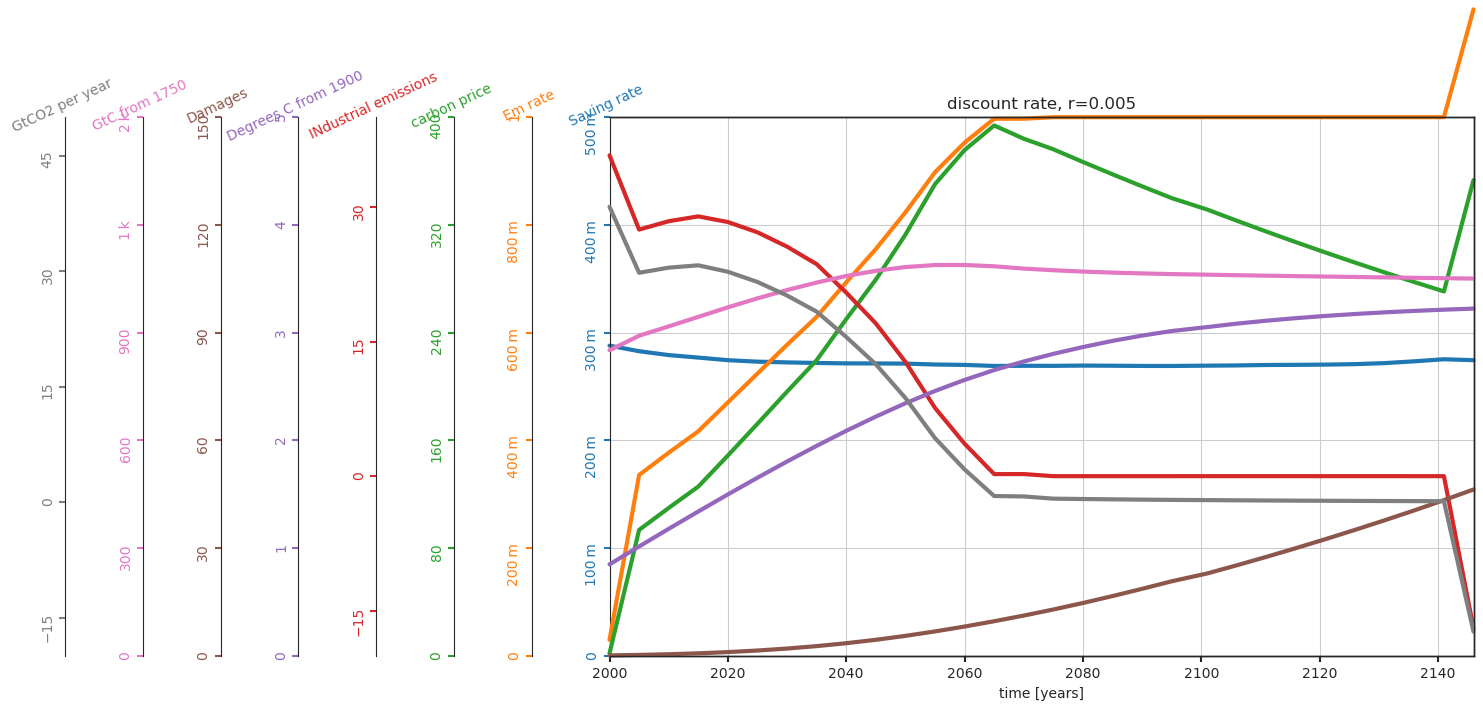

In [11]:
for prstp in [0.015, 0.005]:  
    dice = dicelib.DICE()
    dice.init_parameters(prstp=prstp)
    dice.init_variables()
    controls_start,controls_bounds=dice.get_control_bounds_and_startvalue()
    dice.optimize_controls(controls_start,controls_bounds)
    dice.roll_out(dice.optimal_controls)
    dice.plot_run('discount rate, r='+str(prstp))

How are the differences in these two sets of projections consistent with the change in the discount rate? 

## Case 4 The utility function

These models use an elasticity of consumption when defining the utility function that serves as the basis for the value definition. Here, the elasticity parameter is the exponent called `elasmu`. Let's look at the definitions of the utility:

In [12]:
# def fPERIODU(iC, il, index):
#     return ((iC[indddex]*1000/il[index])**(1-elasmu) - 1) / (1 - elasmu) - 1

Let's vary this elasticity exponent

Optimization terminated successfully    (Exit mode 0)
            Current function value: -4517.318955182418
            Iterations: 95
            Function evaluations: 19232
            Gradient evaluations: 95
Optimization terminated successfully    (Exit mode 0)
            Current function value: 11793.11260614493
            Iterations: 65
            Function evaluations: 13139
            Gradient evaluations: 65


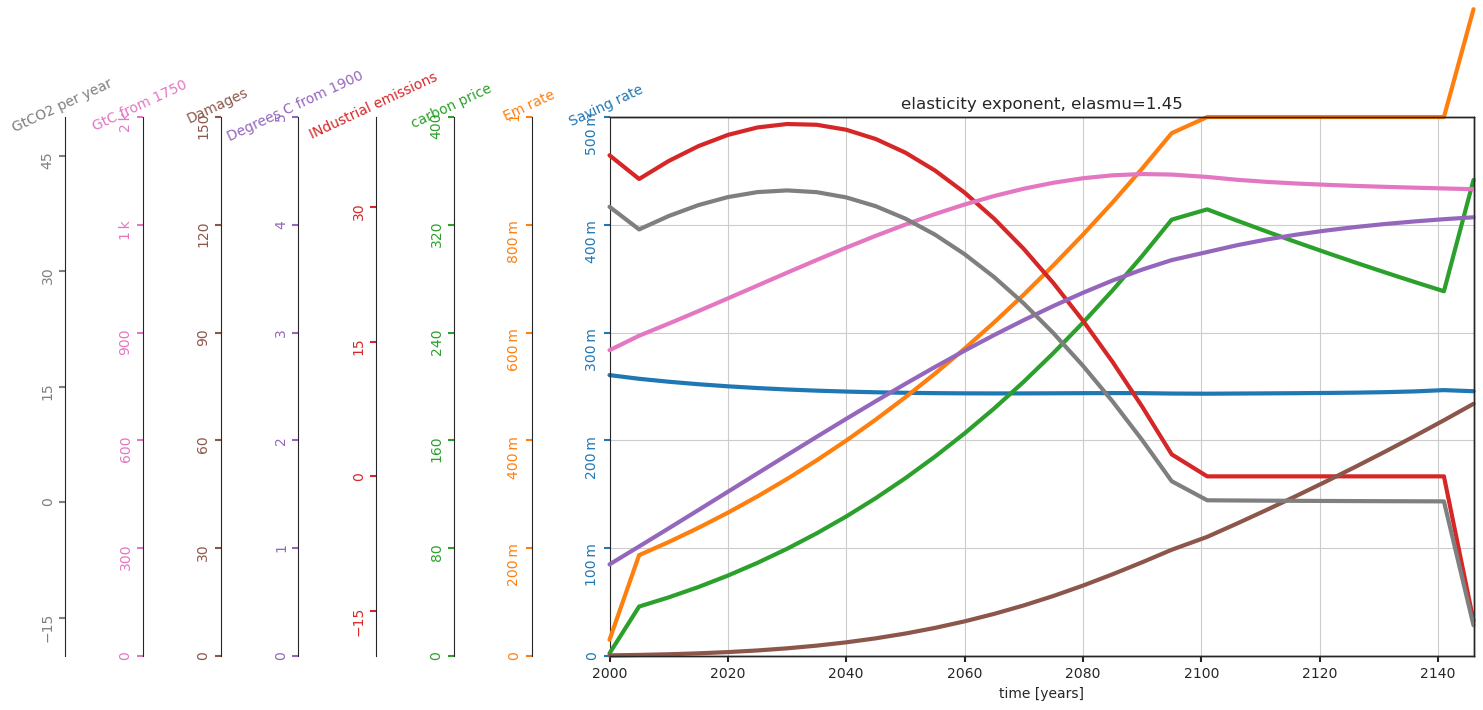

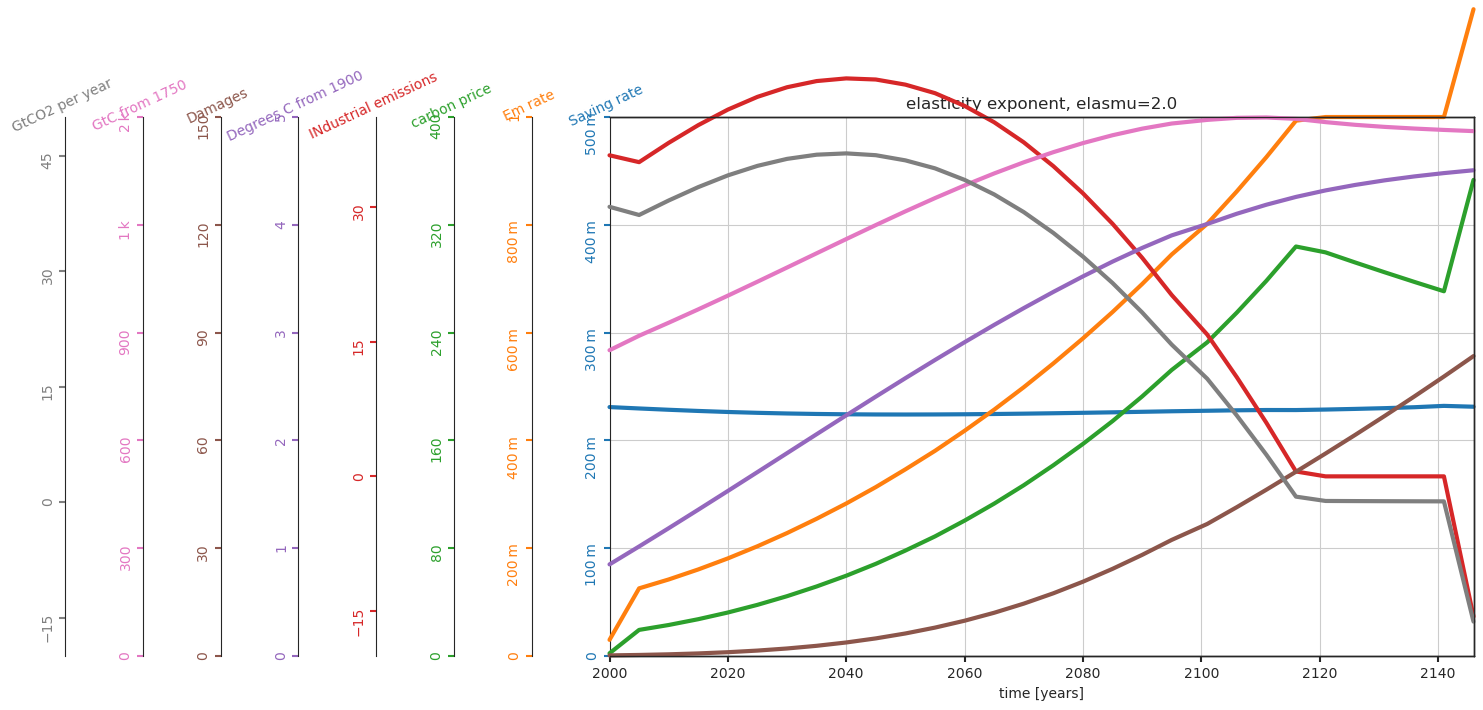

In [13]:
for elasmu in [1.45, 2.0]:  
    dice = dicelib.DICE()
    dice.init_parameters(elasmu=elasmu)
    dice.init_variables()
    controls_start,controls_bounds=dice.get_control_bounds_and_startvalue()
    dice.optimize_controls(controls_start,controls_bounds)
    dice.roll_out(dice.optimal_controls)
    dice.plot_run('elasticity exponent, elasmu='+str(elasmu))

How are the differences in these two sets of projections consistent with the change in the elasticity? 

## Extra 1: Social welfare functions
Local energy use varies with local temperature. Early work used an IAM to argue that climate change would actually lead to a net savings in energy expentidure as colder regions become warmer and require less energy for heating. Does that result of economic benefit pass your smell test? Savings for who? Those in cooler climates! Those in warmer climates would certainly suffer, but they don't use as much energy so their welfare wasn't affecting this calculation. Perhaps we should weight averting suffering over energy savings? 

A regional version of the DICE model is called the RICE model. There are nice python implementations of these, e.g. the RICE-N model https://github.com/mila-iqia/climate-cooperation-competition. In that competition they use a utilitarian social welare function. Alternatively, a prioritarian social welfare function would transform the utilities before summing such that increases from lower utility are valued more than those from higher utility (*c.f.* Adler et al. *Nat. Clim. Change* (2017)). What would varying the elasticity of this social welfare function do?

## Extra 2: tipping points

How might tipping points be incorporated into this model? What effect would they have (*c.f.* Cai et al. *Nat. Clim. Change* (2016)).